In [1]:
import PowerSensor as ps
import numpy as np
import cv2 as cv
import time
from IPython.display import clear_output

In [2]:
debug_flag = True

In [3]:
cam = ps.ImageSensor()

blue


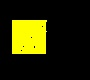

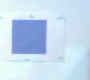

4.08892823057


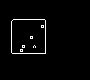

KeyboardInterrupt: 

In [13]:
while True:
    if debug_flag:
        time0 = time.time()
    frame = cam.read_img_ori()
    if debug_flag:
        # ps.CommonFunction.show_img_jupyter(frame)
        # time1 = time.time()
        # fps = 1 / (time1 - time0)
        # print fps
        pass
    roi = frame[170:250, 350:440].copy()
    mask = np.zeros(roi.shape, roi.dtype)
    if debug_flag:
        pass
        # ps.CommonFunction.show_img_jupyter(roi)
    # 给明显的蓝绿红在mask上着色
    blue_pixel = 0
    green_pixel = 0
    red_pixel = 0
    # 0表示蓝，1表示绿，2表示红
    color = -1
    for i in range(roi.shape[0]):
        for j in range(roi.shape[1]):
            # print(frame.item(i, j, 0), frame.item(i, j, 1), frame.item(i, j, 2))
            if (roi.item(i, j, 0) - roi.item(i, j, 1) > 50) and (roi.item(i, j, 0) - roi.item(i, j, 2) > 50):
                color = 0
                blue_pixel += 1
                # print('blue')
                # print(frame.item(i, j, 0), frame.item(i, j, 1), frame.item(i, j, 2))
                mask[i, j] = [0, 255, 255]
            elif (roi.item(i, j, 1) - roi.item(i, j, 0) > 30) and (roi.item(i, j, 1) - roi.item(i, j, 2) > 30):
                color = 1
                green_pixel += 1
                # print('green')
                # print(frame.item(i, j, 0), frame.item(i, j, 1), frame.item(i, j, 2))
                mask[i, j] = [255, 0, 255]
            elif (roi.item(i, j, 2) - roi.item(i, j, 1) > 30) and (roi.item(i, j, 2) - roi.item(i, j, 0) > 30):
                color = 2
                red_pixel += 1
                # print('red')
                # print(frame.item(i, j, 0), frame.item(i, j, 1), frame.item(i, j, 2))
                mask[i, j] = [255, 255, 0]
    # 判断图像的颜色
    if blue_pixel > 100 or green_pixel > 100 or red_pixel > 100:
        if blue_pixel > green_pixel and blue_pixel > red_pixel:
            color = 0
        elif green_pixel > blue_pixel and green_pixel > red_pixel:
            color = 1
        elif red_pixel > blue_pixel and red_pixel > green_pixel:
            color = 2
        else:
            pass
    else:
        pass
    # 根据判断出的颜色去除mask中的其他颜色
    if color != -1:
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask.item(i, j, color) != 0:
                    mask[i, j] = [0, 0, 0]
                # else:
                #     mask[i, j] = [255, 255, 255]
    if debug_flag:
        clear_output(wait=True)
        if blue_pixel > 100 or green_pixel > 100 or red_pixel > 100:
            if blue_pixel > green_pixel and blue_pixel > red_pixel:
                print 'blue'
            elif green_pixel > blue_pixel and green_pixel > red_pixel:
                print 'green'
            elif red_pixel > blue_pixel and red_pixel > green_pixel:
                print 'red'
            else:
                print 'unknown color'
        else:
            print 'unknown color'
        ps.CommonFunction.show_img_jupyter(mask)
        ps.CommonFunction.show_img_jupyter(roi)
        time1 = time.time()
        fps = 1 / (time1 - time0)
        print fps
    # 腐蚀膨胀
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    erode = cv.erode(mask, kernel)
    dilate = cv.dilate(erode, kernel)
    # 边缘检测
    canny = cv.Canny(dilate, 120, 120 * 3)
    ps.CommonFunction.show_img_jupyter(canny)
    try:
        # 找圆
        circles = cv.HoughCircles(image=canny, method=cv.HOUGH_GRADIENT,
                                  dp=1, minDist=200, param1=50, param2=20,
                                  minRadius=5, maxRadius=25)
        circles = np.uint16(np.round(circles))
        for i in circles[0, :]:
            cv.circle(roi, (i[0], i[1]), i[2], (0, 0, 255), 2)
            print "circle:", i[2]
        ps.CommonFunction.show_img_jupyter(roi)
        time.sleep(0.1)
    except:
        pass